 # Lab 2 Genetic Algorithms
  
 ### By Alejandra, Roja, and Franklin
 
 MATH0154 Computational Statistics with Prof. 😂Gabe Chandler😂


 ## How Genetic Algorithms Work
 
 Genetic algorithms work by taking clues from biology on how to find solutions to certain problems. Through an iterative process of combining possible solutions, better and better solutions can be found by selecting "good" traits and ignoring "bad" traits from input solutions.
 
 In order for a genetic algorithm to work, we must define a few entities and operations. First and foremost, an "organism" must be defined. An organism should represent a possible solution to the problem. The "fitness" of the organism should be easily computable - we should define a metric that is high for organisms close to the true solution, and low for organisms that are far away.
 
 We then need to define a "breeding" operation: an operation that combines traits from two parent organisms to produce a child organism with traits from both. 
 
 Once this breeding operation is defined, we can select organisms that will breed based on their fitness value. That is, organisms with higher fitness will get to reproduce more often therefore will produce more children.  After breeding, we eliminate a certain fraction of the least fit organisms. The children generation can then be allowed to breed with themselves and produce fitter and fitter offspring with each iteration.
 
 Optionally, we can introduce a "mutation" operation. The purpose of this operation is to introduce characteristics into offspring that did not exist in either parent. The mutation operation occurs after breeding but before the least fit organisms are removed.
 
 In the context of maximizing a function, we can define organisms to be x-values which may (or may not) be the global maximum of the function. The "fitness" of each organism will be computed by evaluating the function at the organism point. We define a breeding operation to be taking two organisms, and picking a random uniform between those two organisms. This allows for the creation of multiple unique children from the same two parents. We define a mutation operation to be adding a random uniform between some $[-\epsilon, \epsilon]$  to the organism. This will allow for children that are not necessarily between the two parents on the number line. In the following code blocks, we implement this algorithm.

We will first define a function with many local maxima, but only one global maximum. This is the function that we will find the maximum of using a genetic algorithm.

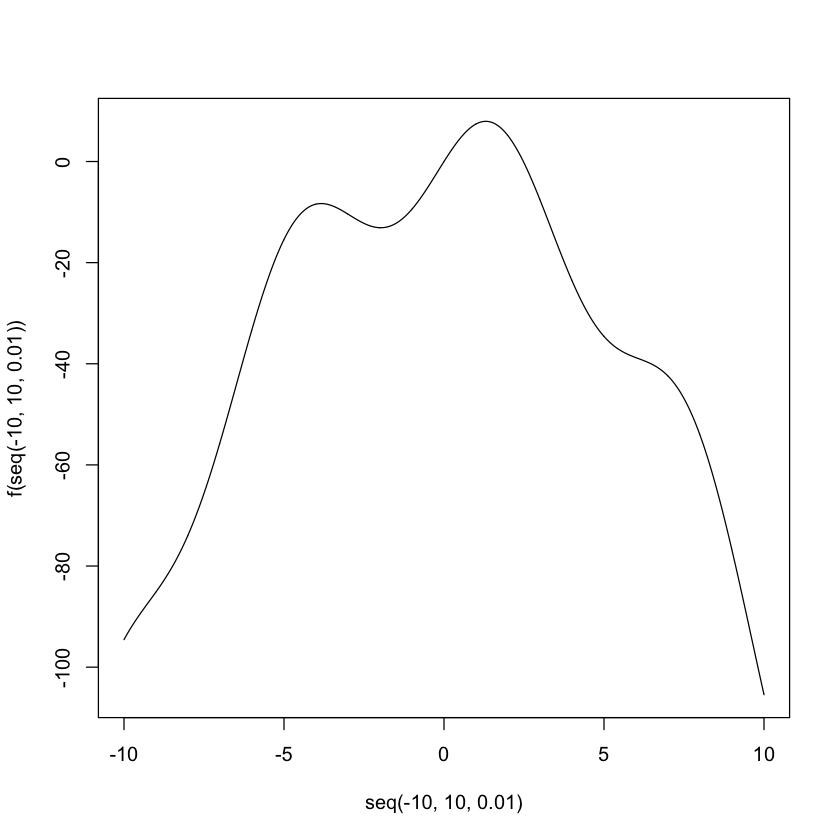

In [276]:
f <- function(x) {
    #
    # an example function that we hope to find the maximum of
    #
    # Args:
    #    x: value to evaluate the function at
    # Returns:
    #    y: f(x)
    
  return(-x^{2} + 10*sin(x))
}

plot(seq(-10,10, 0.01),f(seq(-10,10, 0.01)), type = 'l')

In these next cells we will code the functions that are the building blocks of the genetic algorithm.

In [2]:
Gen0 <- function(n, locale) {
    #
    # a function to generate the 0th generation in a genetic algorithm
    #
    # Args:
    #    n: number of members per generation
    #    locale: a vector where the first value is the left bound of the generati
    #    and the second value is the right bound of the generation
    # Returns:
    #    Gen0: a vector of length n which returns the first generation
    
  return(runif(n, locale[1],locale[2]))
} 

In [263]:
BreedProb <- function(orgs, f) {
    #
    # computes breeding probabilities when given a list of organisms and a function
    #
    # Args:
    #    orgs: a vector of organisms
    #    f: the function on which to evaluate the breeding probabilities
    # Returns:
    #    output: a dataframe containing the input column (orgs) and a column named p which ar
    #    the breeding probabilities. 
    
  p <- exp(f(orgs))/sum(exp(f(orgs))) #probability of breeding array, length n organisms
  df <- data.frame(orgs,p) #make a dataframe out of the vectors
  output <- df[order(df$p),] # orders by probability, ascending 
  return(output) # we want to return organisms ordered by probability of reproduction
}

Breed <- function(bp, n, k) { # functionally this has stayed the same
    #
    # return the next generation in a genetic algorithm, given a dataframe of breeding probabilties.
    #
    # Args:
    #    bp: a dataframe of breeding probabilities as returned by BreedProb
    #    n: number of separate breeding interactions desired
    #    k: number of children per breeding interaction
    # Returns:
    #    gen1: a vector of length n * k of possible entries for the next generation
    
    parents <- list() #initialize a list of possible parent pairs
    babies <- list() #initialize a list to hold baby generations.
    
    for (i in (1:n)){ #pick two parents, n times
        parents[[i]] <- sort(sample(bp$orgs, size = 2, replace = FALSE,  prob = bp$p))
    }
    
    for (j in (1:length(parents))) { # for each pair of parents, perform the breeding operation K times
        babies[[j]] <- runif(k, parents[[j]][1],parents[[j]][2]) 
    }
    
    return(unlist(babies))
    }

Mutate <- function(new_gen, eps, pct) {
    #
    # induce mutation in a percentage of the input generation
    #
    # Args:
    #    new_gen: a vector of input organisms to be mutated
    #    eps: the maximum magnitude of the mutation
    #    pct: the percentage of the generation to be mutated
    # Returns:
    #    new_gen: the new generation with mutations in place

    
    n <- as.integer((pct/100.0)*length(new_gen))
    
    mutated_indices <- sample((1:length(new_gen)), n)
    mutated <- new_gen[mutated_indices] + runif(n, -eps, eps)
    new_gen[mutated_indices] <- mutated
    
    return(new_gen)
    
    }

Select <- function(bp, cutoff) {
    #
    # a function to select only the fittest individuals.
    #
    # Args:
    #    bp: dataframe of organisms and breeding probabilities
    #    cutoff: the number of organisms that will survive
    # Returns:
    #    survived: vector of survived organisms with length cutoff.
    
    return(tail(bp, cutoff)$orgs)
}


In the next cell, we have constructed these functions in a while loop, which will run the genetic algorithm until a certain stopping criterion has been reached. The stopping criterion that we have selected is that the intragenerational standard deviation. If all organisms in one generation have a standard deviation that is less than a certain tolerance, then we will stop the algorithm because we have a set of solutions that is good enough for our needs.

In [282]:
generations <- list(Gen0(10, c(-10,10))) #intialize the first generation as the first entry in a list of generations

std <- sd(generations[[1]]) # the starting standard deviation
tol <- 0.001 #the tolerance for stopping the algorithm
i <- 2 #set the starting i to initialize the loop

while (std > tol) { # if the intragenerational standard deviation less than a certain tolerance, stop
    bp <- BreedProb(generations[[i-1]], f) #compute initial breeding probabilities
    new_gen <- Breed(bp,10,10) #perform the breeding operation, returning 100 children
    mutated <- Mutate(new_gen, std, 10) #perform a mutation algorithm on 10% of the sample
    
    new_bp <- BreedProb(mutated, f) #compute breeding probabilities for children
    generations[[i]] <- Select(new_bp,10) #append the 10 fittest organisms in the children to the new generation
    std <- sd(generations[[i]]) #compute the standard deviation of the 10 new organisms
    i <- i+1 #add one to the index
}

gen_vector <- unlist(generations) #turn the list of all organisms into a vector
final_xy <- data.frame(gen_vector, f(gen_vector)) #evaluate the function for each organism
sol <- tail(final_xy[order(final_xy$f.gen_vector),],1)$gen_vector #pick the fittest organism in al generations

We will print the list of the organisms in each generation. It looks like it took five generations to acheive convergence within our tolerance of 0.001.

In [287]:
generations

[[1]]
 [1]  6.675559  2.720110 -4.067428 -3.335715  6.022380 -7.368542 -6.467711
 [8] -8.000465 -9.158223  9.375037

[[2]]
 [1] 1.580837 1.034604 1.055709 1.073029 1.079624 1.515941 1.481953 1.197699
 [9] 1.372331 1.338113

[[3]]
 [1] 1.343478 1.343415 1.341839 1.340630 1.272706 1.339835 1.273136 1.336770
 [9] 1.335176 1.284047

[[4]]
 [1] 1.297521 1.315345 1.298503 1.298923 1.300059 1.311363 1.309504 1.303883
 [9] 1.308616 1.307916

[[5]]
 [1] 1.304971 1.305224 1.307463 1.307252 1.307128 1.306917 1.306871 1.306707
 [9] 1.306640 1.306283

We can see how fast the algorithm converges by plotting the difference between each organism and the best organism, as a function of iteration. In the following log plot, a new generation occurs every 10 organisms.

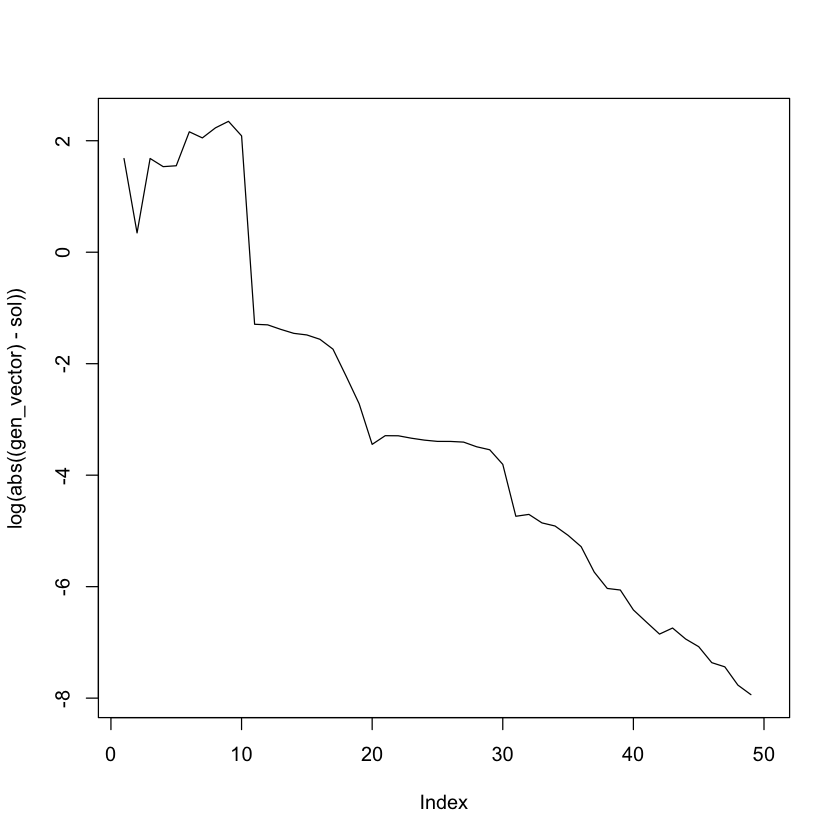

In [289]:
plot(log(abs((gen_vector) - sol)), type = 'l')

By plotting the value of the best solution found by the genetic algorithm and the original function we can verify that we have found a global maximum.

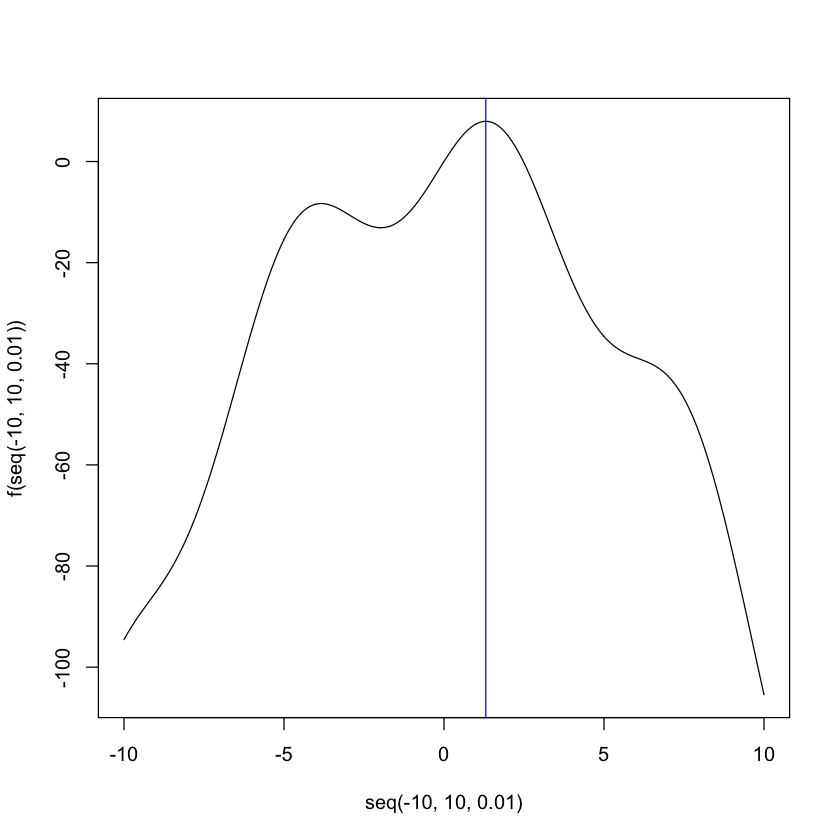

In [286]:
print(sol)
plot(seq(-10,10, 0.01),f(seq(-10,10, 0.01)), type = 'l')
abline(v = sol, col = 'blue')

Looks good! 👏 🙌 🍻